> ### **Start**

In [20]:
import os, random, glob, cv2, torch
from pathlib import Path
from enum import Enum
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms

# --- Metrics & evaluation ---
from torchmetrics.classification import (
    MulticlassAccuracy, 
    MulticlassPrecision, 
    MulticlassRecall, 
    MulticlassF1Score
)

# --- Reproducibility ---
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [2]:
# Traffic sign classes aligned with GTSRB (0–42)
class TrafficSignClass(Enum):
    SPEED_LIMIT_20 = "Speed limit (20km/h)"
    SPEED_LIMIT_30 = "Speed limit (30km/h)"
    SPEED_LIMIT_50 = "Speed limit (50km/h)"
    SPEED_LIMIT_60 = "Speed limit (60km/h)"
    SPEED_LIMIT_70 = "Speed limit (70km/h)"
    SPEED_LIMIT_80 = "Speed limit (80km/h)"
    END_SPEED_LIMIT_80 = "End of speed limit (80km/h)"
    SPEED_LIMIT_100 = "Speed limit (100km/h)"
    SPEED_LIMIT_120 = "Speed limit (120km/h)"
    NO_PASSING = "No passing"
    NO_PASSING_VEH_OVER_3_5_TONS = "No passing veh over 3.5 tons"
    RIGHT_OF_WAY_AT_INTERSECTION = "Right-of-way at intersection"
    PRIORITY_ROAD = "Priority road"
    YIELD = "Yield"
    STOP = "Stop"
    NO_VEHICLES = "No vehicles"
    VEH_OVER_3_5_TONS_PROHIBITED = "Veh > 3.5 tons prohibited"
    NO_ENTRY = "No entry"
    GENERAL_CAUTION = "General caution"
    DANGEROUS_CURVE_LEFT = "Dangerous curve left"
    DANGEROUS_CURVE_RIGHT = "Dangerous curve right"
    DOUBLE_CURVE = "Double curve"
    BUMPY_ROAD = "Bumpy road"
    SLIPPERY_ROAD = "Slippery road"
    ROAD_NARROWS_ON_THE_RIGHT = "Road narrows on the right"
    ROAD_WORK = "Road work"
    TRAFFIC_SIGNALS = "Traffic signals"
    PEDESTRIANS = "Pedestrians"
    CHILDREN_CROSSING = "Children crossing"
    BICYCLES_CROSSING = "Bicycles crossing"
    BEWARE_OF_ICE_SNOW = "Beware of ice/snow"
    WILD_ANIMALS_CROSSING = "Wild animals crossing"
    END_SPEED_PASSING_LIMITS = "End speed + passing limits"
    TURN_RIGHT_AHEAD = "Turn right ahead"
    TURN_LEFT_AHEAD = "Turn left ahead"
    AHEAD_ONLY = "Ahead only"
    GO_STRAIGHT_OR_RIGHT = "Go straight or right"
    GO_STRAIGHT_OR_LEFT = "Go straight or left"
    KEEP_RIGHT = "Keep right"
    KEEP_LEFT = "Keep left"
    ROUNDABOUT_MANDATORY = "Roundabout mandatory"
    END_NO_PASSING = "End of no passing"
    END_NO_PASSING_VEH_OVER_3_5_TONS = "End no passing veh > 3.5 tons"

# Create mapping: index -> class name
IDX_TO_CLASS = {i: sign.value for i, sign in enumerate(TrafficSignClass)}

# Create reverse mapping: class name -> index
CLASS_TO_IDX = {sign.value: i for i, sign in enumerate(TrafficSignClass)}

# Helper function
def get_class_name(idx: int) -> str:
    return IDX_TO_CLASS.get(idx, "Unknown")

def get_class_idx(name: str) -> int:
    return CLASS_TO_IDX.get(name, -1)

> ### **PreProcess**

In [3]:
class PreProcess:
    def __init__(self, size=(64, 64), to_grayscale=False, normalize="minmax"):
        self.size = size
        self.to_grayscale = to_grayscale
        self.normalize_method = normalize
    ##################################
    def resize_image(self, image):
        return cv2.resize(image, self.size)
    ##################################
    def convert_to_grayscale(self, image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ##################################
    def reduce_noise(self, image):
        return cv2.GaussianBlur(image, (5, 5), 0)
    ##################################
    def enhance_contrast(self, image):
        if len(image.shape) == 3:
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            lab = cv2.merge((cl, a, b))
            image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        return image
    ##################################
    def normalize_image(self, image):
        if self.normalize_method == "minmax":
            return image.astype(np.float32) / 255.0
        elif self.normalize_method == "standard":
            return (image.astype(np.float32) - np.mean(image)) / (np.std(image) + 1e-8)
        return image
    ##################################
    def brighten_image(self, image, alpha=1.0, beta=50):
        return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    ##################################
    def __call__(self, image):
        # Full pipeline
        image = self.resize_image(image)
        if self.to_grayscale:
            image = self.convert_to_grayscale(image)
        image = self.reduce_noise(image)
        image = self.enhance_contrast(image)
        image = self.normalize_image(image)
        return image

> ### **Segmentation**

In [4]:
class ThresholdingMethods:
    @staticmethod
    def otsu_threshold(image):
        """Global thresholding using Otsu's method"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thresholded
    ##################################
    @staticmethod
    def adaptive_mean(image, block_size=15, C=5):
        """Adaptive mean thresholding (OpenCV optimized)"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C
        )
    ##################################
    @staticmethod
    def chow_kaneko(image, block_size=15):
        """Chow and Kaneko block mean thresholding"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rows, cols = image.shape
        result = np.zeros_like(image)
        for i in range(0, rows, block_size):
            for j in range(0, cols, block_size):
                block = image[i:i + block_size, j:j + block_size]
                threshold = np.mean(block)
                result[i:i + block_size, j:j + block_size] = (block > threshold).astype(np.uint8) * 255
        return result
    ##################################
    @staticmethod
    def cheng_jin_kuo(image, block_size=15, k=0.5):
        """Cheng, Jin, Kuo method using local mean & std"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rows, cols = image.shape
        result = np.zeros_like(image)
        for i in range(0, rows, block_size):
            for j in range(0, cols, block_size):
                block = image[i:i + block_size, j:j + block_size]
                local_mean = np.mean(block)
                local_std = np.std(block)
                threshold = local_mean - k * local_std
                result[i:i + block_size, j:j + block_size] = (block > threshold).astype(np.uint8) * 255
        return result

In [5]:
class ChainCodeExtractor:
    chain_code_direction_8 = {
        (0, 1): 0,   # Right
        (-1, 1): 1,  # Upper-right
        (-1, 0): 2,  # Up
        (-1, -1): 3, # Upper-left
        (0, -1): 4,  # Left
        (1, -1): 5,  # Lower-left
        (1, 0): 6,   # Down
        (1, 1): 7    # Lower-right
    }
    
    sharpening_kernel = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ])
    ##################################
    @staticmethod
    def extract_chain_code(image, max_code_length=None):
        # Convert to grayscale if needed
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
        # Apply sharpening
        sharpened = cv2.filter2D(gray_img, -1, ChainCodeExtractor.sharpening_kernel)
        # Binary threshold
        _, binary_img = cv2.threshold(sharpened, 128, 255, cv2.THRESH_BINARY)
        # Find contours
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not contours:
            return None
        
        largest_contour = max(contours, key=cv2.contourArea)
        chain_codes = []
        
        for i in range(1, len(largest_contour)):
            prev, curr = largest_contour[i - 1][0], largest_contour[i][0]
            dx, dy = curr[0] - prev[0], curr[1] - prev[1]
            direction = ChainCodeExtractor.chain_code_direction_8.get((dx, dy))
            if direction is not None:
                chain_codes.append(direction)
        
        # Fix length
        if max_code_length:
            if len(chain_codes) < max_code_length:
                chain_codes += [0] * (max_code_length - len(chain_codes))
            else:
                chain_codes = chain_codes[:max_code_length]
        
        return chain_codes, binary_img, largest_contour
    ##################################
    @staticmethod
    def process_images(images, num_samples_to_show=10):
        features = []
        max_code_length = 0
        
        # Pass 1: Find max chain code length
        for img in tqdm(images, desc="Finding max chain code length"):
            result = ChainCodeExtractor.extract_chain_code(img)
            if result:
                chain_codes, _, _ = result
                max_code_length = max(max_code_length, len(chain_codes))
        
        # Pass 2: Extract with fixed length
        for idx, img in enumerate(tqdm(images, desc="Extracting chain codes")):
            result = ChainCodeExtractor.extract_chain_code(img, max_code_length)
            if result:
                chain_codes, binary_img, contour = result
                features.append(chain_codes)
                
                if idx < num_samples_to_show:
                    plt.figure(figsize=(12, 4))
                    plt.subplot(1, 2, 1)
                    plt.imshow(img, cmap='gray')
                    plt.title(f"Original Image {idx + 1}")
                    plt.axis('off')
                    plt.subplot(1, 2, 2)
                    plt.imshow(binary_img, cmap='gray')
                    plt.plot(contour[:, 0, 0], contour[:, 0, 1], 'r-', lw=2)
                    plt.title(f"Contour and Binary Image {idx + 1}")
                    plt.axis('off')
                    plt.show()
        return np.array(features)

Extracting chain codes:   0%|          | 0/1 [00:00<?, ?it/s]

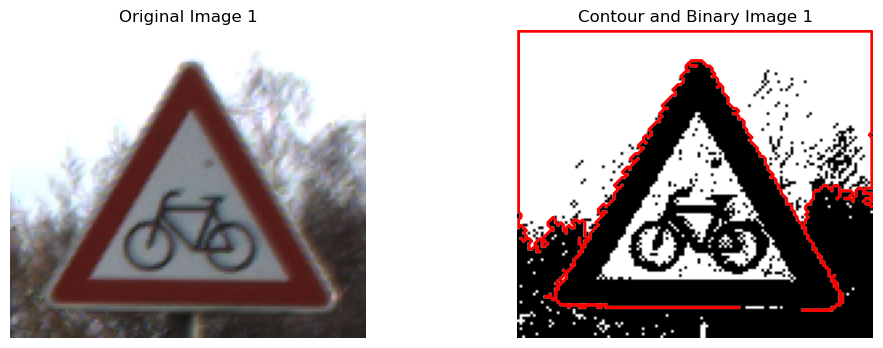

Extracting chain codes: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

----------------------------------------
Extracted Features:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 1 0
  0 0 5 7 7 1 7 0 1 3 7 5 6 7 1 0 0 6 5 7 0 6 3 4 3 5 5 7 0 0 6 5 3 3 5 5
  5 6 4 2 3 4 5 5 7 0 7 5 7 0 0 7 4 4 5 7 6 4 3 5 6 7 5 7 0 0 0 0 0 7 1 0
  1 3 4 4 0 0 7 0 1 0 1 1 0 1 0 1 1 3 7 1 1 1 1 7 1 0 0 0 1 3 4 1 2 6 6 7
  6 7 7 6 6 7 5 6 6 7 6 6 5 6 6 6 7 6 5 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
  6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 4 4 4 5 4
  5 5 5 4 4 5 5 5 4 4 5 5 5 4 5 4 5 5 4 4 5 5 5 3 5 5 5 5 2 1 3 4 5 5 7 5
  5 5 4 4 5 5 5 1 2 3 5 5 5 6 5 2 3 5 5 7 4 5 5 5 1 2 3 5 5 6 5 5 2 3 5 5
  7 3 4 5 7 5 4 3 5 5 5 6 4 5 3 5 5 6 2 3 5 5 5 5 6 4 3 5 5 6 5 4 3 5 5 6
  3 4 5 7 6 6 2 2 3 5 6 6 6 6 7 7 6 7 0 7 1 6 7 0 

In [6]:
image_path = '../Data/Meta/29/00029_00005_00028.png'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)    # Load the image

if image is None:
    print("Error: Image not found. Check the path!")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistent display
    features = ChainCodeExtractor.process_images([image])
    print('-'*40) 
    print("Extracted Features:\n", features)

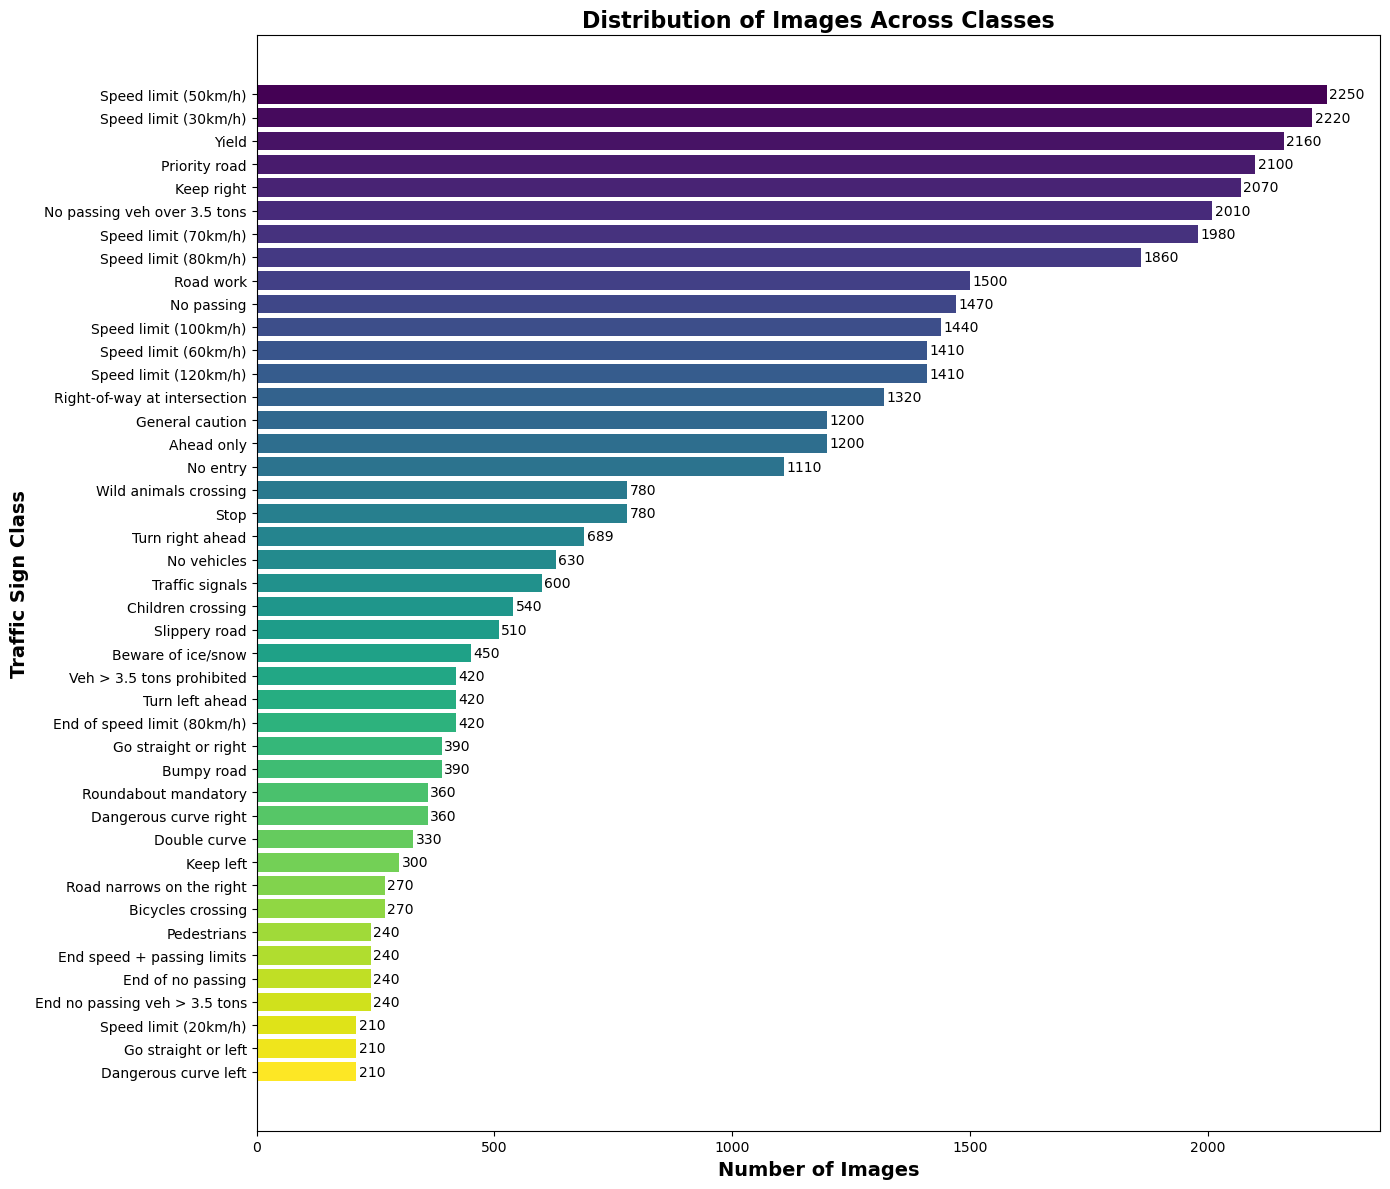

In [8]:
# Define paths
train_path = Path('../Data/Train')
folders = [folder for folder in train_path.iterdir() if folder.is_dir()]

train_number = []
class_num = []

# Collect number of images per class
for folder in folders:
    train_files = list(folder.iterdir())
    if train_files:  # Check if the folder is not empty
        train_number.append(len(train_files))
        class_num.append(IDX_TO_CLASS[int(folder.name)])  # Map folder index to class name

# Sorting the dataset on the basis of number of images in each class (descending for barh)
sorted_pairs = sorted(zip(train_number, class_num), reverse=True)  
train_number, class_num = zip(*sorted_pairs)

# Plotting as horizontal bar chart
plt.figure(figsize=(14, 12))
bars = plt.barh(class_num, train_number, color=plt.cm.viridis(np.linspace(0, 1, len(class_num))))

# Labels & Title
plt.xlabel("Number of Images", fontsize=14, weight='bold')
plt.ylabel("Traffic Sign Class", fontsize=14, weight='bold')
plt.title("Distribution of Images Across Classes", fontsize=16, weight='bold')

# Add values at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,str(width), va='center', fontsize=10)

plt.gca().invert_yaxis()  # To show the largest class at the top
plt.tight_layout()
plt.show()

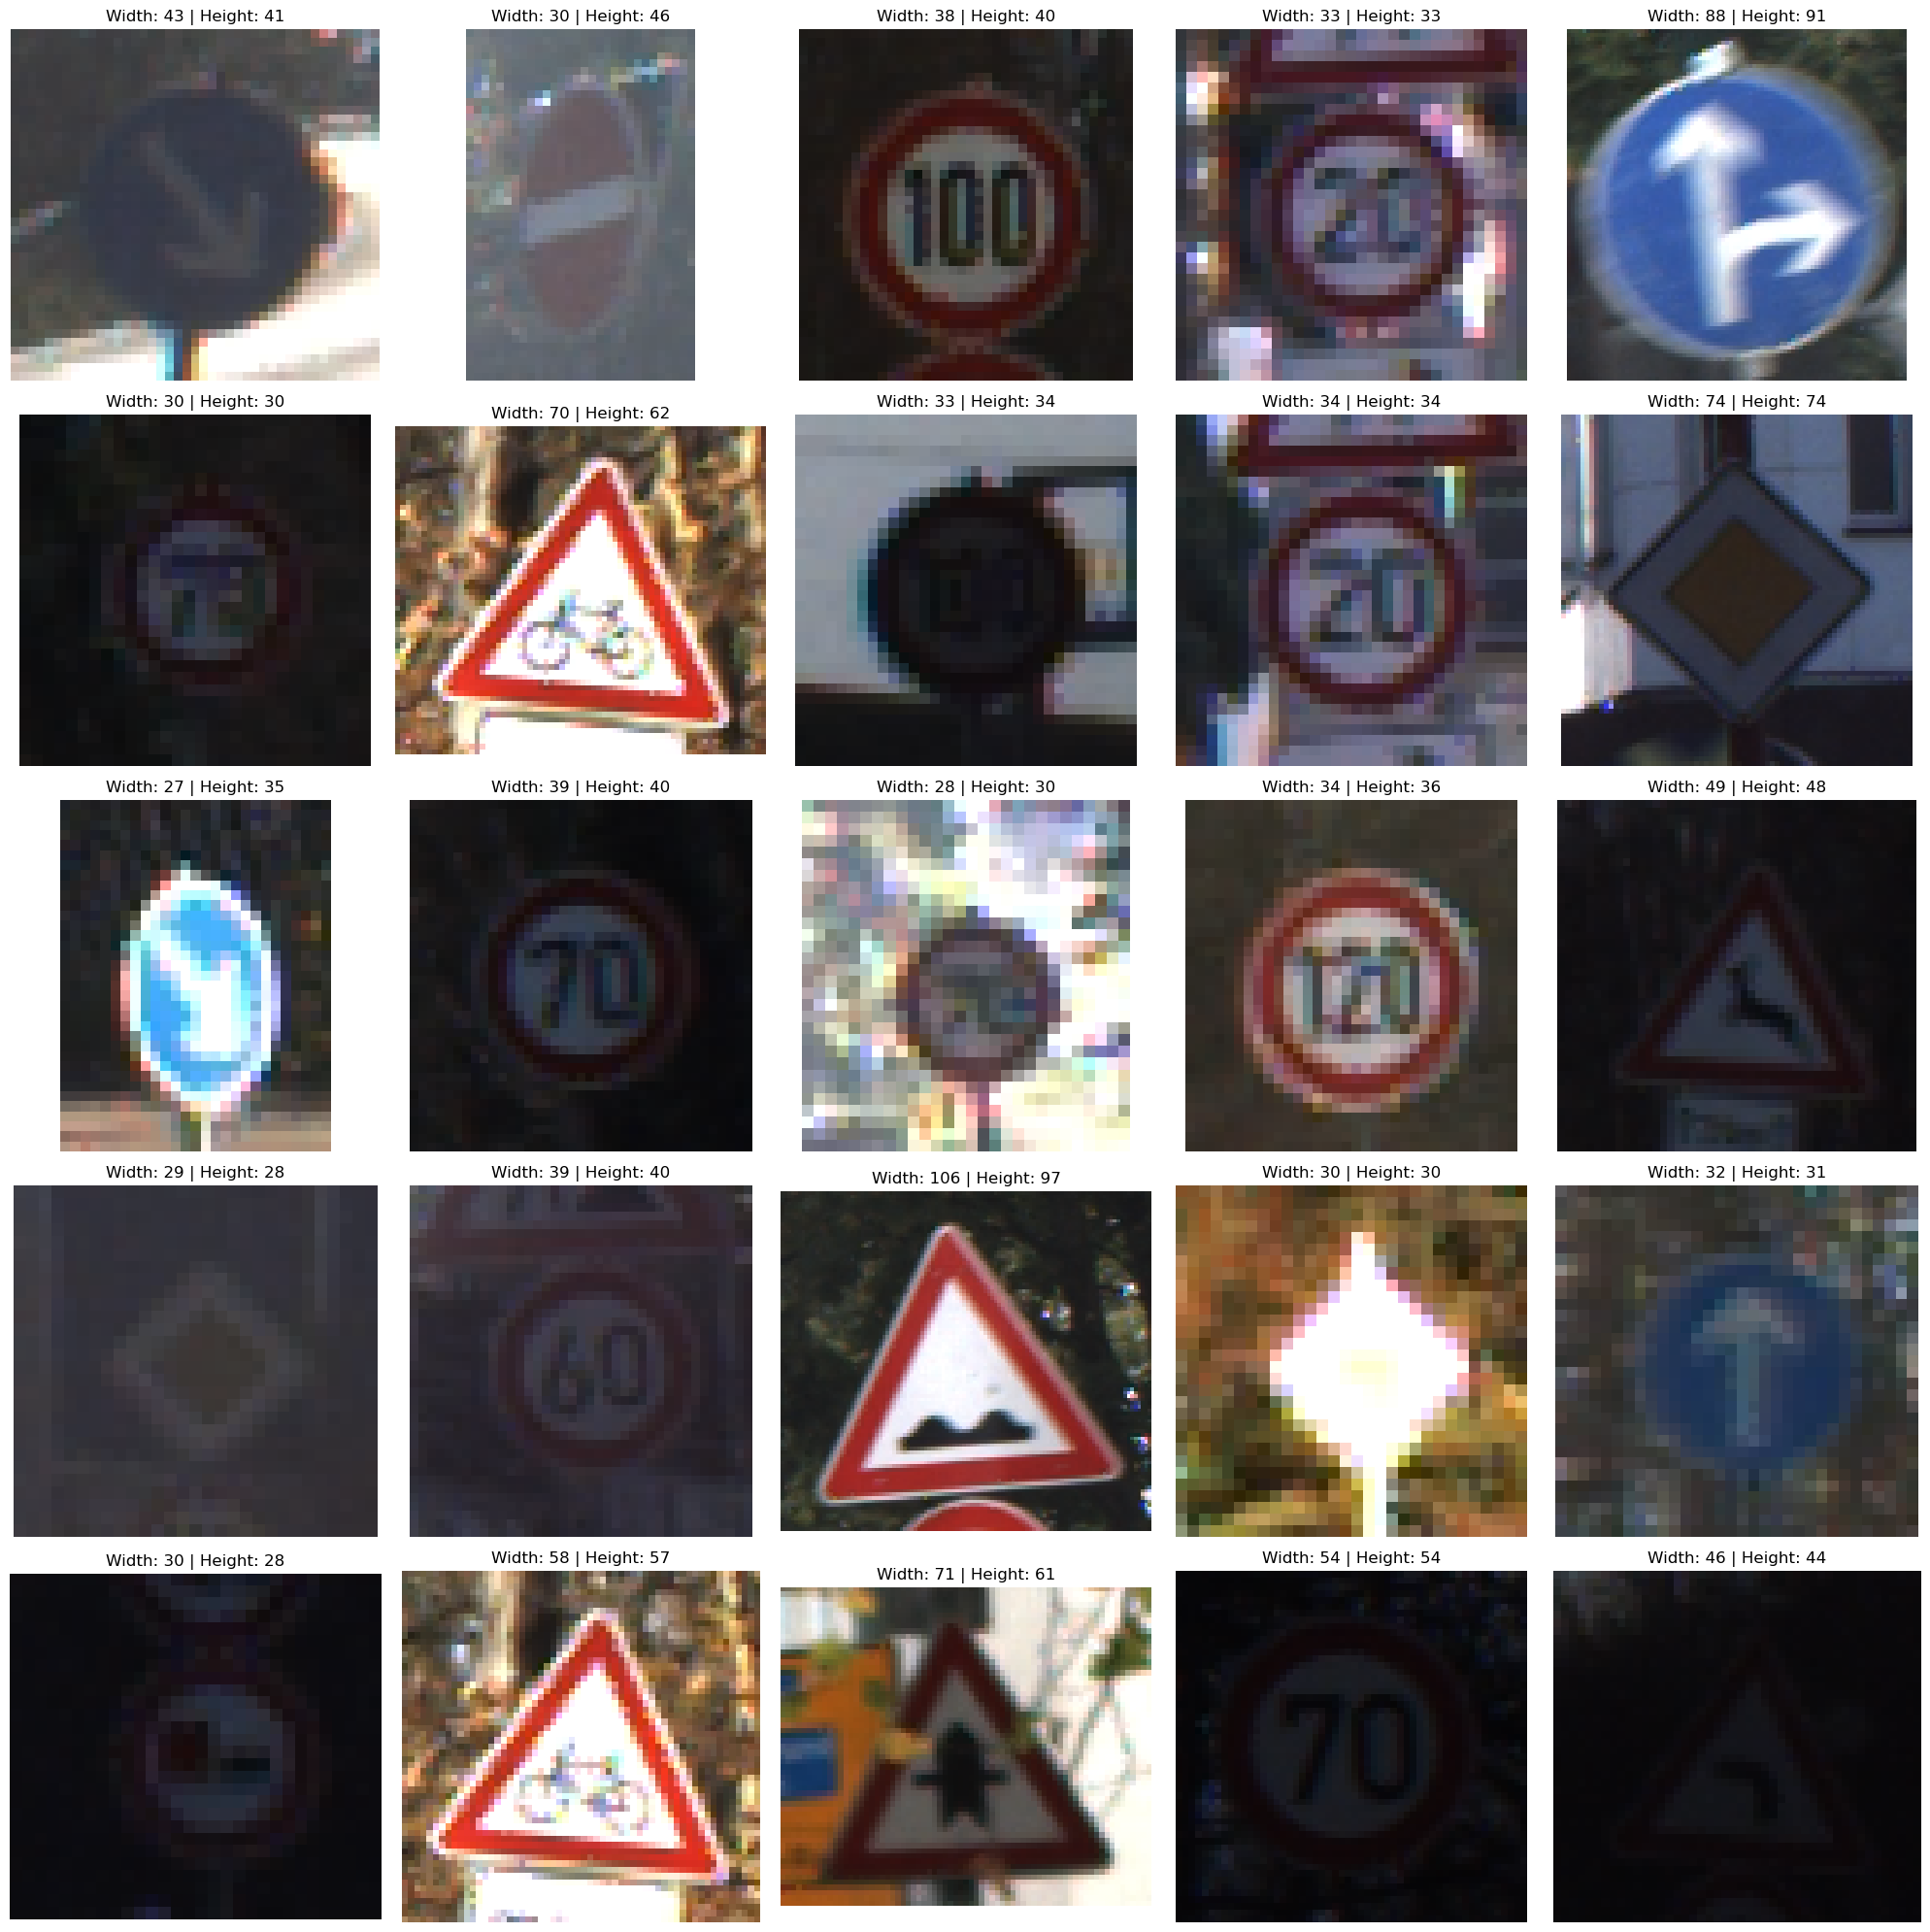

In [11]:
# Load the test data
test = pd.read_csv('../Data/Test.csv')
img_paths = test["Path"].values

# Define the base path
base_path = Path('../Data')

# Pick 25 unique random images
sampled_imgs = random.sample(list(img_paths), min(25, len(img_paths)))

# Display random 25 images from the test set
plt.figure(figsize=(20, 20))

for i, img_rel_path in enumerate(sampled_imgs, 1):
    img_path = base_path / img_rel_path
    
    if img_path.exists():
        img = imread(img_path)
        
        # Handle grayscale vs RGB
        if img.ndim == 2:  
            cmap = "gray"
        else:
            cmap = None
        plt.subplot(5, 5, i)
        plt.imshow(img, cmap=cmap)
        plt.axis("off")
        plt.title(f"Width: {img.shape[1]} | Height: {img.shape[0]}", fontsize=12)
    else:
        print(f"Error: File {img_path} does not exist.")

plt.tight_layout()
plt.show()

> ### **Prepare Data**

In [14]:
num_classes = 43
image_size = (30, 30)  # (width, height)

# Initialize lists for images and labels
images, labels = [], []

# Base training directory
base_path = Path('../Data/Train')

# Load images
for class_label in tqdm(range(num_classes), desc="Loading data"):
    class_dir = base_path / str(class_label)
    if class_dir.is_dir():
        # Use glob to avoid non-image files
        for img_file in glob.glob(str(class_dir / "*.*")):
            img = cv2.imread(img_file, cv2.IMREAD_COLOR)
            if img is not None:
                # Convert BGR -> RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Resize to target size
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(class_label)
            else:
                print(f"Warning: Could not read image {img_file}")

# Convert lists to NumPy arrays
images = np.array(images, dtype=np.uint8)   # Keep as uint8 first
labels = np.array(labels, dtype=np.int64)

# Normalize and convert to torch tensors
images = torch.from_numpy(images).permute(0, 3, 1, 2).float() / 255.0
labels = torch.from_numpy(labels)

# Print shapes for verification
print(f"Images shape: {images.shape}")  # (N, 3, 30, 30)
print(f"Labels shape: {labels.shape}")  # (N,)

Loading data: 100%|██████████| 43/43 [05:44<00:00,  8.02s/it]


Images shape: torch.Size([39209, 3, 30, 30])
Labels shape: torch.Size([39209])


In [15]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, shuffle=True
)

# Ensure correct dtypes
X_train = X_train.float()
X_test  = X_test.float()
y_train = y_train.long()
y_test  = y_test.long()

# Wrap in TensorDataset for easy DataLoader usage
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

# Example DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verification
print(f"X_train Shape: {X_train.shape}")
print(f"X_test  Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test  Shape: {y_test.shape}")

X_train Shape: torch.Size([31367, 3, 30, 30])
X_test  Shape: torch.Size([7842, 3, 30, 30])
y_train Shape: torch.Size([31367])
y_test  Shape: torch.Size([7842])


In [16]:
# Ensure labels are long (needed for classification in PyTorch)
y_train = y_train.long()
y_test  = y_test.long()

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print shapes for verification
print(f"Train set: {len(train_dataset)} samples")
print(f"Test set : {len(test_dataset)} samples")

Train set: 31367 samples
Test set : 7842 samples


> ### **Model**

In [18]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 30 -> 15
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 15 -> 7
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Initialize model & training components
model = CNNModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

> ### **train**

In [19]:
def train_model(model, optimizer, train_loader, criterion, scheduler=None, epochs=10, device="cpu"):
    history = {"loss": [], "accuracy": []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            batch_acc = 100. * correct / total
            progress_bar.set_postfix(batch_loss=loss.item(), acc=f"{batch_acc:.2f}%")
        
        # Scheduler step
        if scheduler:
            scheduler.step()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        history["loss"].append(epoch_loss)
        history["accuracy"].append(epoch_acc)
        print(f"Epoch [{epoch+1}/{epochs}]\t | Loss: {epoch_loss:.4f}\t | Accuracy: {epoch_acc:.2f}%")
    return history

history = train_model(model, optimizer, train_loader, criterion, scheduler=scheduler, epochs=30, device=device)

Epoch [1/30]	 | Loss: 1.7560	 | Accuracy: 46.26%


Epoch [2/30]	 | Loss: 0.9318	 | Accuracy: 67.62%


Epoch [3/30]	 | Loss: 0.7690	 | Accuracy: 72.52%


Epoch [4/30]	 | Loss: 0.6679	 | Accuracy: 75.82%


Epoch [5/30]	 | Loss: 0.6186	 | Accuracy: 77.77%


Epoch [6/30]	 | Loss: 0.5874	 | Accuracy: 78.71%


Epoch [7/30]	 | Loss: 0.5384	 | Accuracy: 80.16%


Epoch [8/30]	 | Loss: 0.4967	 | Accuracy: 81.72%


Epoch [9/30]	 | Loss: 0.4564	 | Accuracy: 83.37%


Epoch [10/30]	 | Loss: 0.4220	 | Accuracy: 84.62%


Epoch [11/30]	 | Loss: 0.3561	 | Accuracy: 86.72%


Epoch [12/30]	 | Loss: 0.3339	 | Accuracy: 87.56%


Epoch [13/30]	 | Loss: 0.3150	 | Accuracy: 88.20%


Epoch [14/30]	 | Loss: 0.3027	 | Accuracy: 88.68%


Epoch [15/30]	 | Loss: 0.2856	 | Accuracy: 89.27%


Epoch [16/30]	 | Loss: 0.2640	 | Accuracy: 90.02%


Epoch [17/30]	 | Loss: 0.2375	 | Accuracy: 91.30%


Epoch [18/30]	 | Loss: 0.2066	 | Accuracy: 92.60%


Epoch [19/30]	 | Loss: 0.1857	 | Accuracy: 93.41%


Epoch [20/30]	 | Loss: 0.1646	 | Accuracy: 94.31%


Epoch [21/30]	 | Loss: 0.1514	 | Accuracy: 94.87%


Epoch [22/30]	 | Loss: 0.1449	 | Accuracy: 95.17%


Epoch [23/30]	 | Loss: 0.1453	 | Accuracy: 95.17%


Epoch [24/30]	 | Loss: 0.1397	 | Accuracy: 95.23%


Epoch [25/30]	 | Loss: 0.1384	 | Accuracy: 95.35%


Epoch [26/30]	 | Loss: 0.1428	 | Accuracy: 95.18%


Epoch [27/30]	 | Loss: 0.1346	 | Accuracy: 95.54%


Epoch [28/30]	 | Loss: 0.1357	 | Accuracy: 95.43%


Epoch [29/30]	 | Loss: 0.1316	 | Accuracy: 95.60%


Epoch [30/30]	 | Loss: 0.1318	 | Accuracy: 95.54%


> ### **test**

Testing:   0%|          | 0/246 [00:00<?, ?it/s]

--------------- Test Set Performance ---------------
Validation Loss: 0.0401
Accuracy       : 0.9926
Precision      : 0.9926
Recall         : 0.9926
F1 Score       : 0.9926

--------------- Classification Report ---------------
                               precision    recall  f1-score   support

         Speed limit (20km/h)       1.00      0.89      0.94        38
         Speed limit (30km/h)       0.99      1.00      0.99       496
         Speed limit (50km/h)       1.00      0.99      0.99       450
         Speed limit (60km/h)       0.99      0.99      0.99       280
         Speed limit (70km/h)       1.00      1.00      1.00       418
         Speed limit (80km/h)       0.97      0.98      0.98       364
  End of speed limit (80km/h)       0.98      1.00      0.99        59
        Speed limit (100km/h)       0.99      0.96      0.97       278
        Speed limit (120km/h)       0.99      0.99      0.99       301
                   No passing       0.99      0.99      0.99 

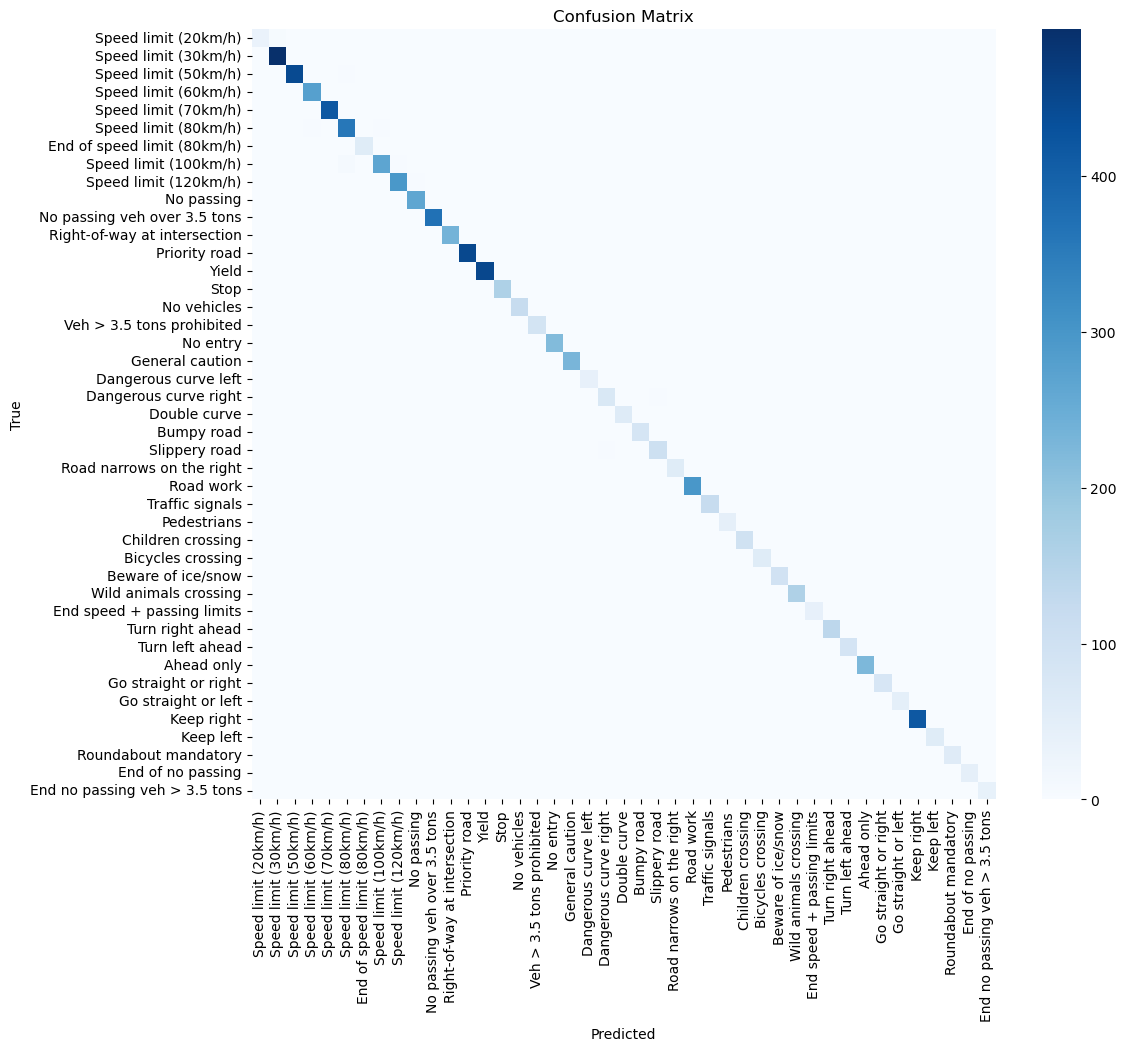

In [25]:
def test_model(model, data_loader, criterion, device, class_names=None):
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []
    
    # Torchmetrics
    accuracy_metric  = MulticlassAccuracy(num_classes=num_classes, average='weighted').to(device)
    precision_metric = MulticlassPrecision(num_classes=num_classes, average='weighted').to(device)
    recall_metric    = MulticlassRecall(num_classes=num_classes, average='weighted').to(device)
    f1_metric        = MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Testing", leave=False)
        for images, targets in progress_bar:
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets.long())
            
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())
            
            accuracy_metric.update(preds, targets)
            precision_metric.update(preds, targets)
            recall_metric.update(preds, targets)
            f1_metric.update(preds, targets)
    
    avg_val_loss = val_loss / len(data_loader)
    
    # Metrics
    val_accuracy  = accuracy_metric.compute().item()
    val_precision = precision_metric.compute().item()
    val_recall    = recall_metric.compute().item()
    val_f1        = f1_metric.compute().item()
    
    print("--------------- Test Set Performance ---------------")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Accuracy       : {val_accuracy:.4f}")
    print(f"Precision      : {val_precision:.4f}")
    print(f"Recall         : {val_recall:.4f}")
    print(f"F1 Score       : {val_f1:.4f}")
    
    # Reset metrics
    accuracy_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    
    # Classification report (per class)
    if class_names:
        print("\n--------------- Classification Report ---------------")
        class_names = [IDX_TO_CLASS[i] for i in range(len(IDX_TO_CLASS))]
        print(classification_report(val_targets, val_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(val_targets, val_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    return avg_val_loss, val_accuracy, val_precision, val_recall, val_f1

val_loss, val_acc, val_prec, val_rec, val_f1 = test_model(model, test_loader, criterion, device, class_names=IDX_TO_CLASS)

> ## **save & Load model**

In [ ]:
# Save only state_dict
torch.save(model.state_dict(), '../models/traffic_sign_model.pth')

In [29]:
# 1. Define the model architecture again
loaded_model = CNNModel(num_classes)  

# 2. Load the weights
# safer way
state_dict = torch.load('../models/traffic_sign_model.pth', weights_only=True)
loaded_model.load_state_dict(state_dict)

# 3. Send to device (GPU/CPU)
loaded_model = loaded_model.to(device)

# 4. Set to eval mode for inference
loaded_model.eval()

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=43, bias=True)
  )
)

> ## **Let's Check the Model Performance**

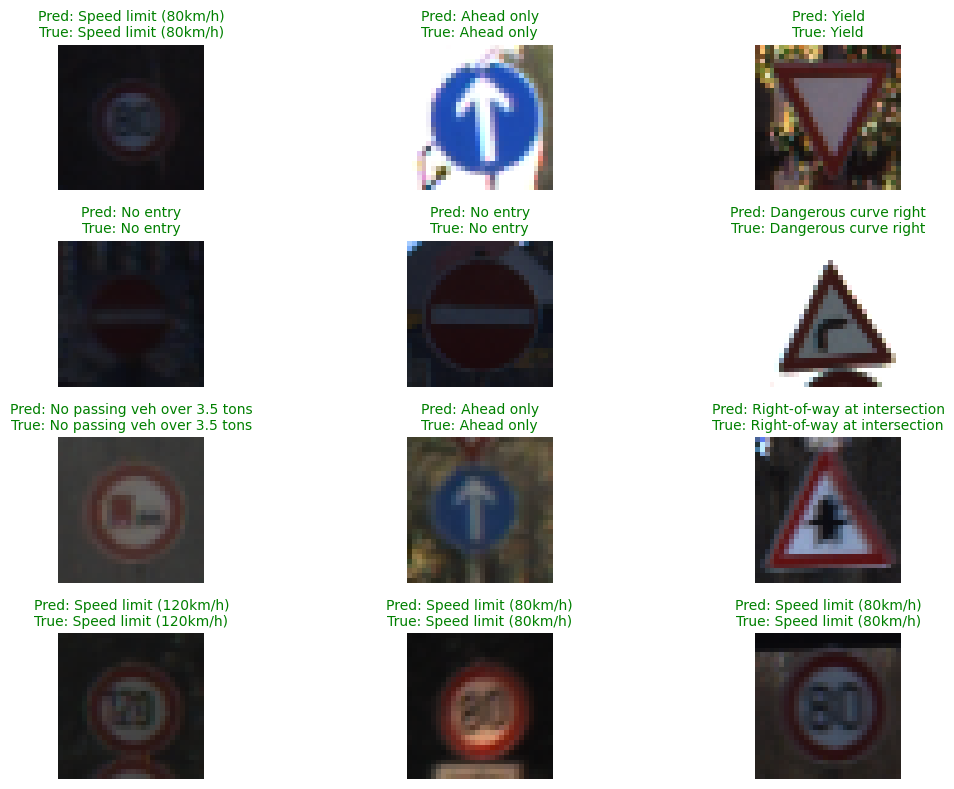

In [31]:
random_indices = random.sample(range(len(test_loader.dataset)), 12)
subset = Subset(test_loader.dataset, random_indices)
random_loader = DataLoader(subset, batch_size=1, shuffle=False)

model.eval()
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
axs = axes.ravel()

with torch.no_grad():
    for i, (img, actual_label) in enumerate(random_loader):
        img = img.to(device)
        actual_label = int(actual_label.item())
        
        # forward pass
        output = model(img)
        prediction = int(output.argmax(dim=1).item())
        
        img_disp = img.squeeze().permute(1, 2, 0).cpu().numpy()
        img_disp = np.clip(img_disp, 0, 1)
        
        # plot
        axs[i].imshow(img_disp)
        col = 'green' if actual_label == prediction else 'red'
        axs[i].set_title(
            f'Pred: {IDX_TO_CLASS[prediction]}\nTrue: {IDX_TO_CLASS[actual_label]}',
            color=col, fontsize=10
        )
        axs[i].axis('off')

plt.tight_layout()
plt.show()

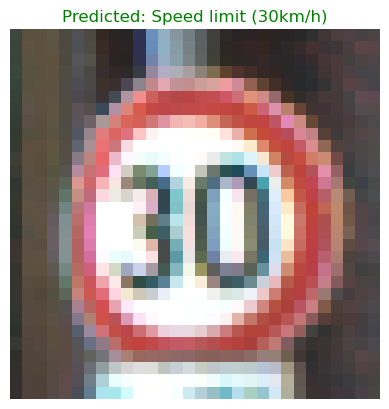

In [34]:
image_path = input("Enter the path to the image: ")
image = Image.open(image_path)

# Preprocessing
pre = PreProcess(size=(30, 30))
image = np.array(image)
image = pre.resize_image(image)
image = pre.normalize_image(image)

# Convert to tensor (N, C, H, W)
preprocessed_img = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()  

# Send to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_for_model = preprocessed_img.to(device)

# Prediction
model.eval()
with torch.no_grad():
    output = model(img_for_model)  
    prediction = int(output.argmax(dim=1).item())

# Visualization
img_for_visualization = preprocessed_img.squeeze().permute(1, 2, 0).cpu().numpy()
img_for_visualization = np.clip(img_for_visualization, 0, 1)

plt.imshow(img_for_visualization)
plt.title(f'Predicted: {IDX_TO_CLASS[prediction]}', color='green')
plt.axis('off')
plt.show()

<div style="background: linear-gradient(135deg,rgba(65, 181, 202, 1),rgb(201, 224, 96)); 
        color:rgba(44, 34, 34, 1); 
        width: 100%; 
        height: 60px; 
        text-align: center; 
        font-weight: bold; 
        line-height: 60px; 
        margin: 2 px 0; 
        font-size: 44px; 
        border-radius: 10px; 
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.3);">
    Thanks for reading 😊
</div>